In [ ]:
# %pip install qubovert
# %pip install qiskit-aer
# %pip install qiskit
# %pip install pylatexenc
# %pip install qiskit-ibm-runtime
# %pip install scikit-learn
# %pip install tensorflow
# %pip install cvxpy
# %pip install pipreqs
import json
import numpy as np
from datetime import datetime
from qubovert import QUBO, boolean_var
from qubovert.sim import anneal_qubo
from qubovert.utils import qubo_to_matrix
import random
import math
import pandas as pd

from qiskit.circuit.library import QAOAAnsatz
from qiskit.quantum_info import SparsePauliOp
from qiskit import QuantumCircuit, transpile

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 798.3/798.3 kB 6.0 MB/s eta 0:00:00
  DEPRECATION: Building 'docopt' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'docopt'. Discussion can be found at https://github.com/pypa/pip/issues/6334
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13781 sha256=9cb0c9456707eedd2d048333b441af18ec422e950da90d6d5c49d1aaf2576221
  Stored in directory: /home/gambero/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built docopt
  Attempting uninstall: ipython╺━━━━━━━━━━━━━━━━ 11/19 [bleach]ve]
    Found existing installation: ipython 8.36.0━━━━━━━━━━━━━━

In [100]:
def filter_dates_before(input_dict, specified_date):
    """
    Filters the input dictionary to include only entries with dates before the specified date.

    Parameters:
    input_dict (dict): A dictionary with dates as keys in 'yyyy-mm-dd' format.
    specified_date (str): A date in 'yyyy-mm-dd' format to filter the dictionary.

    Returns:
    dict: A new dictionary containing only the entries with dates before the specified date.
    """
    if specified_date is None:
        return input_dict
    # Convert the specified date string to a datetime object
    specified_date_obj = datetime.strptime(specified_date, '%Y-%m-%d')
    
    # Create a new dictionary to hold the filtered results
    filtered_dict = {}
    
    # Iterate through the input dictionary
    for date_str, data in input_dict.items():
        # Convert the date string to a datetime object
        date_obj = datetime.strptime(date_str, '%Y-%m-%d')
        
        # Check if the date is before the specified date
        if date_obj < specified_date_obj:
            filtered_dict[date_str] = data
            
    return filtered_dict

In [101]:
def read_input_file(input_file_name:str,
                    date_limit:str=None,
                    max_assets:int=None):
    '''Given a file, it returns the data related to it,
    ignoring data before `date_limit`
    '''
    with open(input_file_name, 'r') as file:
        data = json.load(file)
    
    ######################
    # DATA PREPROCESSING #
    ######################


    # Select only `max_assets` at random (for debuggin purposes)
    if max_assets:
        asset_names = list(data['assets'].keys())
        selected_asset_names = random.sample(asset_names, max_assets)
        
        for a in list(data['assets'].keys()):
            if a not in selected_asset_names:
                data['assets'].pop(a)


    # Filter out all assets with a number of history items different than the trend (i.e. 751)
    # We recognize that this approach works well only in cases where the number of outliers is reduced
    # as in this case (9 out of ~900 assets).

    filtered_data = {key:data[key] for key in ['evaluation_date']}
    filtered_data['assets'] = {}
    for a in data['assets']:
        if len(data['assets'][a]['history']) == 751:
            filtered_data['assets'][a] = data['assets'][a]

    data = filtered_data
    
    # Filter by date
    for a in data['assets']:
        # print(a)
        data['assets'][a]['history'] = filter_dates_before(data['assets'][a]['history'], date_limit)

    
    return  data


In [102]:
data = read_input_file("../eth_hackathon/input_one_day.json", max_assets=10, date_limit="2022-12-15")

In [103]:
def covariance_matrix(data):
    '''Returns the covariance matrix of the assets in `data`
    using history up to date `date_limit`'''

    assets = list(data['assets'].keys())
    # number of history elements (assumed to be equal for all assets)
    num_history_dates = len(data['assets'][assets[0]]['history'])
    # print(num_history_dates)
    # number of assets we are taking into account
    N_considered_assets = len(data['assets'])

    # Each row of assets_matrix represents a variable, and each column a single observation of all those variables.
    assets_matrix = np.empty((N_considered_assets, num_history_dates))

    for i, asset in enumerate(assets):
        history = data['assets'][asset]['history']
        ##TODO add filtering by date
        assets_matrix[i, :] = list(history.values())

    return np.corrcoef(assets_matrix)


In [104]:
cvm = covariance_matrix(data)


In [105]:

# model = QUBO()
# P = 0
# # bool_vars = np.zeros_like(cvm).tolist()

# triui = np.triu_indices_from(cvm, k=1)
# for k in range(len(triui[0])):
#     i = triui[0][k]
#     j = triui[1][k]
#     # bool_vars[i][j] = boolean_var(f'x{i}_{j}')
#     var = boolean_var(f'x_{i}_{j}')
#     model += var * cvm[i][j]


# portfolio_size = 6

# # add slack variables to implement constraint
# k = math.ceil(math.log2(portfolio_size//2))
# s_variables = [boolean_var(f's_{i}_s') for i in range(k)]
# tmp_model = QUBO()
# for i in range(len(s_variables)):
#     tmp_model+= s_variables[i] * (2 ** i)

# model+= P*(tmp_model - portfolio_size//2)**2

# solution = anneal_qubo(model, num_anneals=10).best




In [106]:
# model = QUBO()

# # for each non zero element of the matrix add to the model
# # the formula on the pdf (multiplied by the weight of the edge which
# # is not reported there)
# x = [boolean_var(f"x_{i}") for i in range(cvm.shape[0])]
# for i, row in enumerate(cvm):
#     for j, weight in enumerate(row):
#         if weight != 0:
#             # apart for the weight this is the formula on the pdf
#             model += weight*(2*x[i]*x[j] - x[i] - x[j])
# model = -model

In [107]:
# def get_selected_assets(data, sol):
#     '''Given the solution of the optimization,
#     it returns a dataset with name and history of the 
#     selected assetes'''

#     asset_names = list(data['assets'].keys())
#     def parse_bool_var(x):
#         name, i, j = x.split('_')
#         if name == 'x':
#             return int(i), int(j)
#         return None, None 
    
#     selected_assets_ids = ()
#     for x in sol.state:
#         if sol.state[x] == 1:
#             i, j = parse_bool_var(x)
#             if i is not None and j is not None:
#                 selected_assets_ids = (*selected_assets_ids, i, j)
    
#     selected_assets = {asset_names[i]: data['assets'][asset_names[i]] for i in selected_assets_ids}

#     with open('selected_assets.json', 'w') as fp:
#         json.dump(selected_assets, fp)
#     return selected_assets

# sel_assets = get_selected_assets(data, solution)
# print(sel_assets.keys())

In [108]:
# # np.set_printoptions(formatter={'float': lambda x: f"{x:10.4g}"})
# def qubo_to_ising(model: QUBO):
#     qubo = model.to_qubo()
#     qubo_mat_dim = qubo.num_binary_variables
#     # np_qubo = np.zeros((qubo_mat_dim,qubo_mat_dim))

#     pauli_list = []
#     # Z = ZGate().to_matrix()
#     # HC = np.zeros_like(np_qubo)
#     for i in range(qubo_mat_dim):
#         for j in range(qubo_mat_dim):
#             if (qubo[i,j] == 0):
#                 continue
            
#             s = ['I' for i in range(qubo_mat_dim)]
#             s[i] = 'Z'
#             s[j] = 'Z'
#             pauli_list.append((''.join(s), qubo[i,j]))
#     HC = SparsePauliOp.from_list(pauli_list)
#     ansatz = QAOAAnsatz(HC, reps=2)
#     return ansatz, HC


# # qubo_to_ising(model).decompose(reps=3).draw('mpl', scale=0.2, fold=200)
# ansatz, cost_hamiltonian = qubo_to_ising(model)
# ansatz.measure_all()
# # ansatz.draw('mpl')
# # ansatz.decompose(reps=3).draw('mpl', scale=0.2, fold=200)
# ansatz.parameters


In [ ]:
num_assets = cvm.shape[0]
print(num_assets)

9


In [110]:

# qc = QuantumCircuit(num_assets)
import numpy as np
from scipy.sparse import csr_matrix, kron, eye

def pauli_z_sparse():
    """Returns the sparse Pauli Z matrix."""
    return csr_matrix([[1, 0], [0, -1]])

Z = pauli_z_sparse()
I = eye(2, format='csr')  # Sparse identity matrix of size 2
def z_j_sparse(n, j):
    """Returns the sparse matrix Z_j for n qubits applied to qubit j."""

    # Start with the identity matrix for n qubits
    result = I

    for i in range(1, n + 1):
        if i == j:
            result = kron(result, Z, format='csr')  # Apply Z to qubit j
        else:
            result = kron(result, I, format='csr')  # Apply I to other qubits

    return result

# Example usage
n = num_assets  # Number of qubits
j = 5   # Index of the qubit to apply Z
# Z_j_matrix_sparse = z_j_sparse(n, j)

# print("Sparse matrix Z_{} for {} qubits:".format(j, n))
# print(Z_j_matrix_sparse.toarray())  # Convert to dense array for display if needed

HC = np.zeros_like(z_j_sparse(n, 1))
bigI = np.eye(z_j_sparse(n, 1).shape[0])

for j in range(num_assets):
    HC = 1/2 * (bigI - z_j_sparse(n, j) + HC)

delta = 1000

triui = np.triu_indices_from(cvm, k=1)
for t in range(len(triui[0])):
    j = triui[0][t]
    k = triui[1][t]
    HC = 1/4 * (bigI - z_j_sparse(n, j) - z_j_sparse(n, k) + np.kron(z_j_sparse(n,j), z_j_sparse(n,k)))
    # HC = np.kron(z_j_sparse(n,j), z_j_sparse(n,k))

cost_hamiltonian = SparsePauliOp.from_operator(HC)


SparsePauliOp(['IIIIIIIIII', 'IIIIIIIIZI', 'IIIIIIIZII', 'IIIIIIIZZI'],
              coeffs=[ 0.25+0.j, -0.25+0.j, -0.25+0.j,  0.25+0.j])


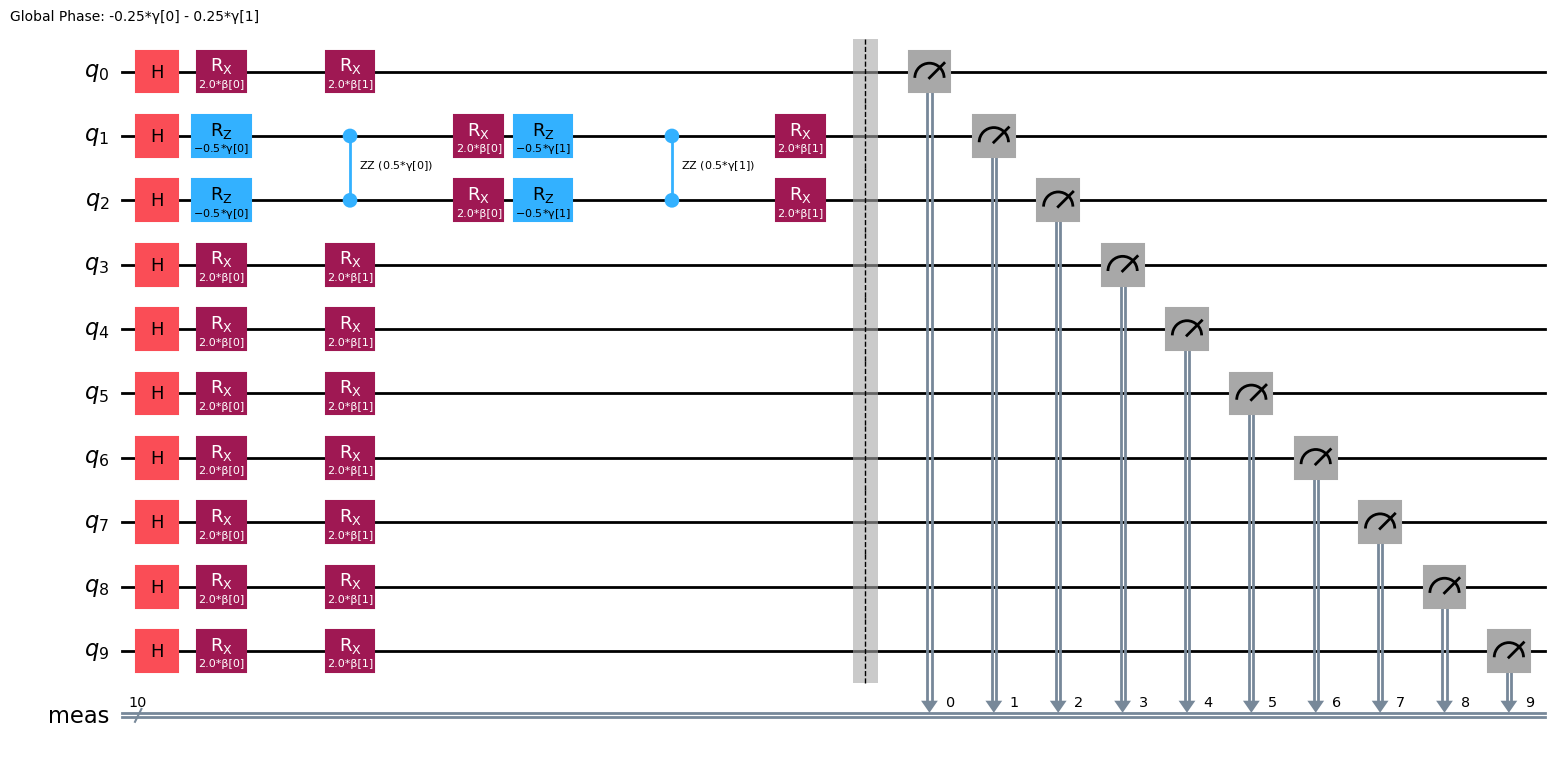

In [111]:
from qiskit.circuit.library import qaoa_ansatz
print(cost_hamiltonian)
ansatz = qaoa_ansatz(cost_operator=cost_hamiltonian, reps=2)
ansatz.measure_all()

ansatz.draw('mpl')

In [112]:
initial_gamma = np.pi
initial_beta = np.pi/2
init_params = [initial_gamma, initial_beta, initial_gamma, initial_beta]

In [113]:
def cost_func_estimator(params, ansatz, hamiltonian, estimator):

    # transform the observable defined on virtual qubits to
    # an observable defined on all physical qubits
    isa_hamiltonian = hamiltonian.apply_layout(ansatz.layout)

    pub = (ansatz, isa_hamiltonian, params)
    job = estimator.run([pub])

    results = job.result()[0]
    cost = results.data.evs

    objective_func_vals.append(cost)


    return cost

In [115]:
from qiskit_ibm_runtime import Session, EstimatorV2 as Estimator
from scipy.optimize import minimize
from qiskit_aer import AerSimulator
backend = AerSimulator(method='statevector')
ansatz = transpile(ansatz, backend)
objective_func_vals = [] # Global variable
with Session(backend=backend) as session:
    # If using qiskit-ibm-runtime<0.24.0, change `mode=` to `session=`
    estimator = Estimator(mode=session)
    estimator.options.default_shots = 1000

    # Set simple error suppression/mitigation options
    estimator.options.dynamical_decoupling.enable = True
    estimator.options.dynamical_decoupling.sequence_type = "XY4"
    estimator.options.twirling.enable_gates = True
    estimator.options.twirling.num_randomizations = "auto"

    result = minimize(
        cost_func_estimator,
        init_params,
        args=(ansatz, cost_hamiltonian, estimator),
        method="COBYLA",
        tol=1e-2,
    )
    print(result)

/home/gambero/QubiTO/zurich hackaton/.venv/lib/python3.10/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:269: UserWarning: Options {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XY4'}, 'twirling': {'enable_gates': True, 'num_randomizations': 'auto'}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")


 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: 1.3877787807814457e-17
       x: [ 3.001e+00  4.317e-01  3.026e+00  1.571e+00]
    nfev: 26
   maxcv: 0.0


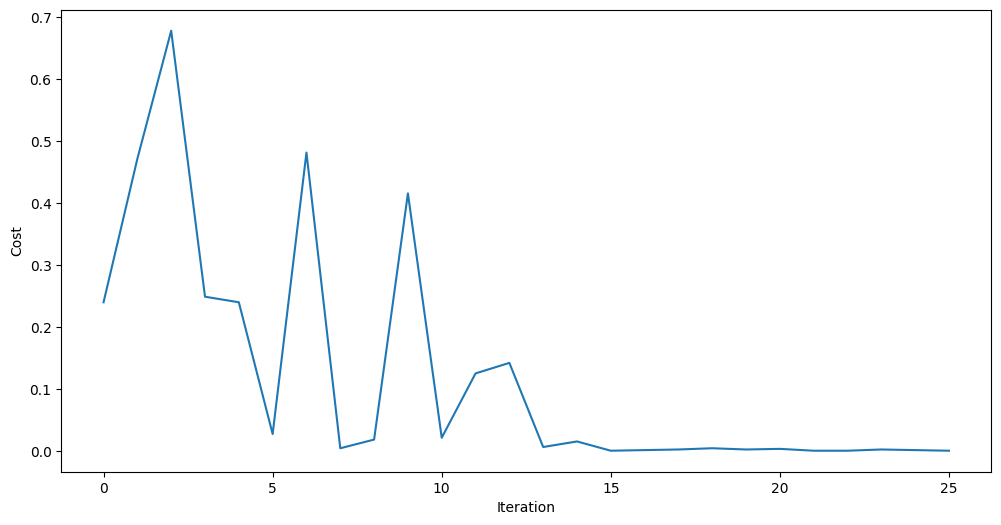

In [117]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(objective_func_vals)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()

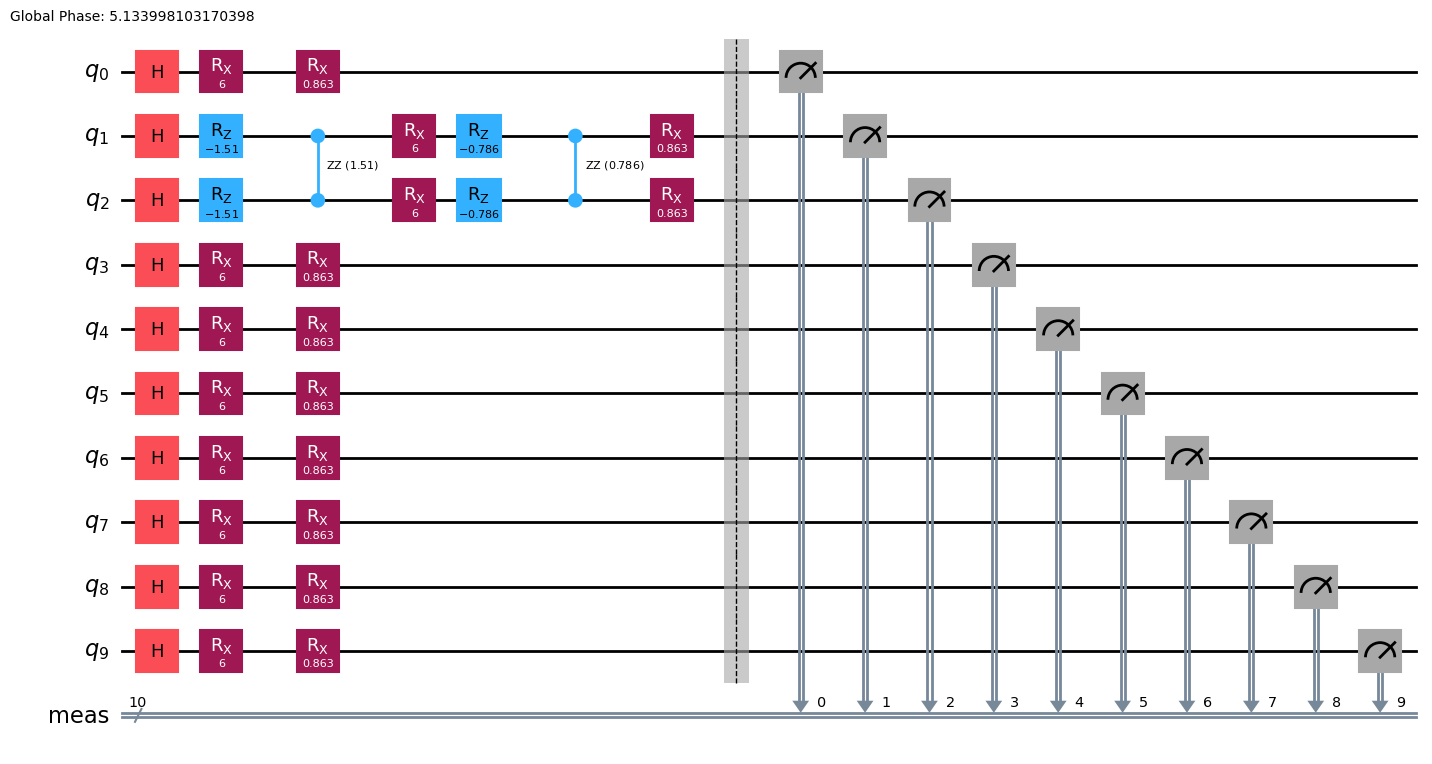

In [119]:
optimized_circuit = ansatz.assign_parameters(result.x)
optimized_circuit.draw('mpl', fold=False, idle_wires=False)

In [120]:
from qiskit_ibm_runtime import SamplerV2 as Sampler

# If using qiskit-ibm-runtime<0.24.0, change `mode=` to `backend=`
sampler = Sampler(mode=backend)
sampler.options.default_shots = 10000

# Set simple error suppression/mitigation options
sampler.options.dynamical_decoupling.enable = True
sampler.options.dynamical_decoupling.sequence_type = "XY4"
sampler.options.twirling.enable_gates = True
sampler.options.twirling.num_randomizations = "auto"

pub= (optimized_circuit, )
job = sampler.run([pub], shots=int(1e4))
counts_int = job.result()[0].data.meas.get_int_counts()
counts_bin = job.result()[0].data.meas.get_counts()
shots = sum(counts_int.values())
final_distribution_int = {key: val/shots for key, val in counts_int.items()}
final_distribution_bin = {key: val/shots for key, val in counts_bin.items()}
# print(final_distribution_int)

/home/gambero/QubiTO/zurich hackaton/.venv/lib/python3.10/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:269: UserWarning: Options {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XY4'}, 'twirling': {'enable_gates': True, 'num_randomizations': 'auto'}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")


In [121]:
# auxiliary functions to sample most likely bitstring
def to_bitstring(integer, num_bits):
    result = np.binary_repr(integer, width=num_bits)
    return [int(digit) for digit in result]

keys = list(final_distribution_int.keys())
values = list(final_distribution_int.values())
most_likely = keys[np.argmax(np.abs(values))]
most_likely_bitstring = to_bitstring(most_likely, cvm.shape[0])
most_likely_bitstring.reverse()

print("Result bitstring:", most_likely_bitstring)

Result bitstring: [0, 0, 1, 1, 0, 0, 0, 1, 1]


/tmp/ipykernel_181962/3823459478.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax.get_children()[int(p)].set_color("tab:purple")


TypeError: only length-1 arrays can be converted to Python scalars

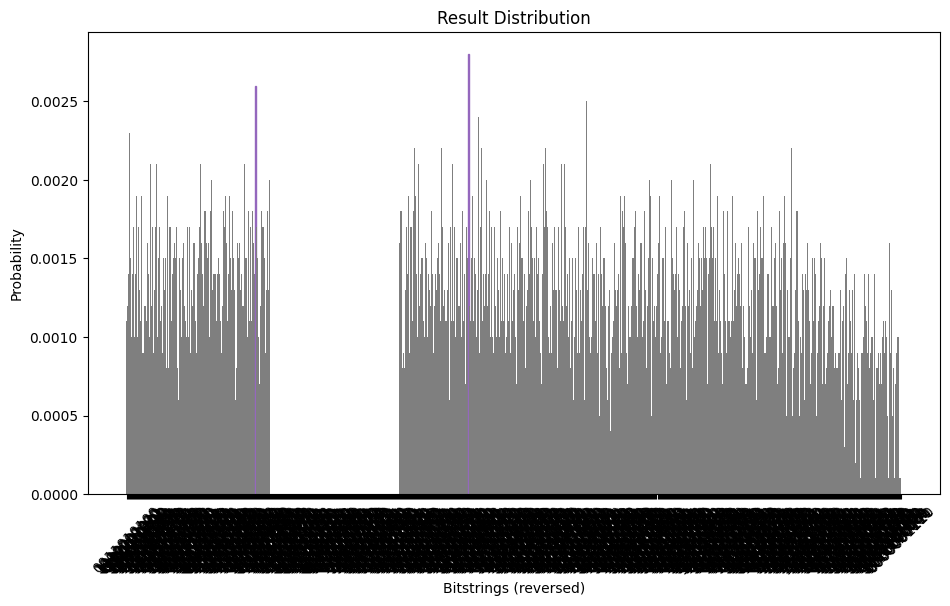

In [122]:
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams.update({"font.size": 10})
final_bits = final_distribution_bin
values = np.abs(list(final_bits.values()))
top_4_values = sorted(values, reverse=True)[:4]
positions = []
for value in top_4_values:
    positions.append(np.where(values == value)[0])
fig = plt.figure(figsize=(11, 6))
ax = fig.add_subplot(1, 1, 1)
plt.xticks(rotation=45)
plt.title("Result Distribution")
plt.xlabel("Bitstrings (reversed)")
plt.ylabel("Probability")
ax.bar(list(final_bits.keys()), list(final_bits.values()), color="tab:grey")
for p in positions:
    ax.get_children()[int(p)].set_color("tab:purple")
plt.show()